In [7]:
import sys
import os

from utils.data_func import *
from utils.plots_func import *
import config.const as const
from flim_analysis.preprocessing.segmentation import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Segmentation Quality Control

This notebook contains the **quality control process** for segmentation results of FLIM tissue samples. The goal is to identify and remove erroneous segmentations based on area size.

## Process Overview:

1. **Check Area Distribution**  
   Visualize the distribution of segmented region sizes to detect potential outliers (e.g., unusually small or large regions).

2. **Define Filtering Thresholds (Based on Domain Expert Guidance)**  
   - Remove regions with an area **less than the 5th percentile** or **greater than 100**.
   - Assess how much data would be excluded using these thresholds.

### Extract leaps list and category

In [8]:
df_category_with_rcb, all_leap_list, df_category_all = extract_core_resection_from_tnbc(const.RCB_FILE, for_prediction=False)

Core Responder Count: 31
Core Non-Responder Count: 26
Resection Count: 18


In [9]:
resection_leaps_list = list(df_category_with_rcb[df_category_with_rcb['sample_type'] == 'resection']['leap_ID'].values)
core_leaps_list = list(df_category_with_rcb[df_category_with_rcb['sample_type'] == 'core']['leap_ID'].values)
len(core_leaps_list), len(resection_leaps_list)

(57, 18)

In [10]:
leaps_list = all_leap_list

### Step 1: Check Area Distribution

We begin by analyzing the distribution of segmented cell areas to identify potential outliers.

In [5]:
results = Parallel(n_jobs=-1)(delayed(process_leap_extract_area)(leap_number, const.SEG_DIR) for leap_number in all_leap_list)

2025-10-06 14:03:45.386674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:03:45.386674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:03:45.386939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:03:45.386942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:03:45.386927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for 

In [6]:
combined_df = pd.concat(results, ignore_index=True)

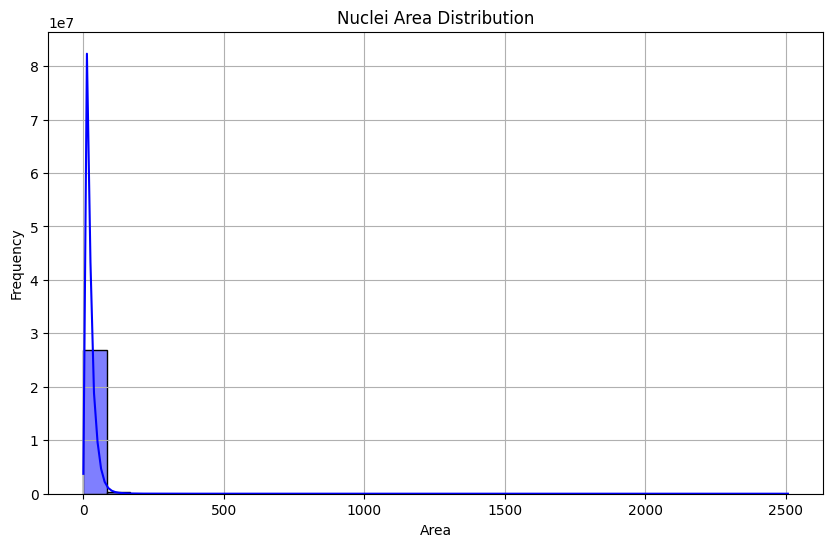

In [7]:
plot_hist_plt(combined_df,'Nuclei Area Distribution', 'Area')

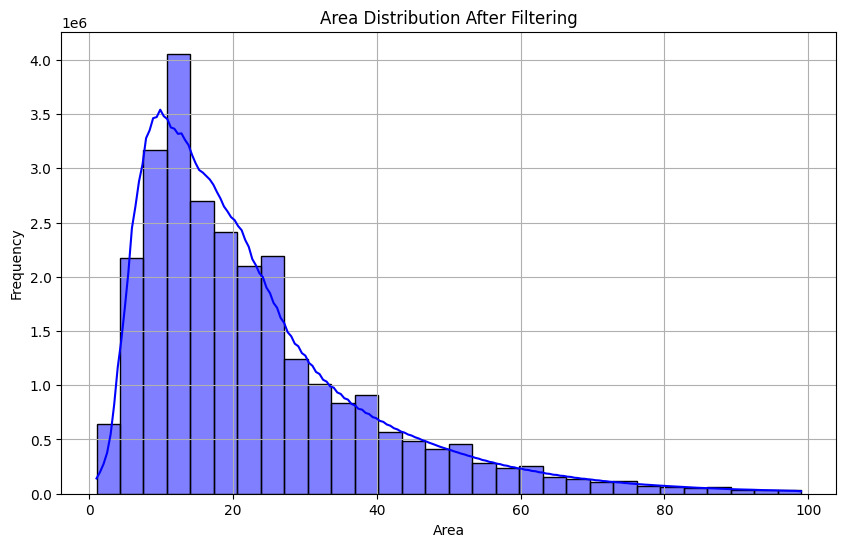

In [10]:
filtered_df = combined_df[combined_df['area'] < 100]
plot_hist_plt(filtered_df,'Area Distribution After Filtering', 'Area')

### Step 2: Define Thresholds and Evaluate Impact

Based on domain expert guidance, we use these thresholds:
- **Lower bound:** 5th percentile of area values
- **Upper bound:** Area > 100 is considered too large to be a nucleus

We calculate:
- How many segments fall outside this range
- What percentage of the data this would remove

In [11]:
# Use Joblib to parallelize the computation
results = Parallel(n_jobs=-1)(delayed(process_leap_qc)(leap_number, const.SEG_DIR) for leap_number in leaps_list)

# Collect the results into their respective lists
leaps_list_results, lower_percent_list, upper_percent_list, lower_list, upper_list, lower_area_list, upper_area_list = zip(*results)

# Flatten area lists
lower_area_list = [area for sublist in lower_area_list for area in sublist]
upper_area_list = [area for sublist in upper_area_list for area in sublist]


2025-10-06 14:48:24.650777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:48:24.651733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:48:24.652013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:48:24.652706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 14:48:24.672032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for 

leap 015, lower num: 2684, lower percent: 0.05935689327259056, upper num: 574, upper percent: 0.012694059887655358
leap 022, lower num: 3817, lower percent: 0.051830427461843465, upper num: 57, upper percent: 0.0007739938080495357
leap 028, lower num: 1501, lower percent: 0.0515984874527329, upper num: 209, upper percent: 0.00718459951873496
leap 021, lower num: 12467, lower percent: 0.08285042132964725, upper num: 38, upper percent: 0.0002525319652303357
leap 019, lower num: 10572, lower percent: 0.05614743215253067, upper num: 97, upper percent: 0.0005151627808168251
leap 030, lower num: 2358, lower percent: 0.055843694493783305, upper num: 1011, upper percent: 0.02394316163410302
leap 017, lower num: 17914, lower percent: 0.08196001281054124, upper num: 532, upper percent: 0.0024340028366198474
leap 032, lower num: 1406, lower percent: 0.06202302704133398, upper num: 623, upper percent: 0.02748246504036349
leap 023, lower num: 11238, lower percent: 0.06497531192543854, upper num: 62

process_executor.py (700): A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
2025-10-06 14:50:25.157364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759751425.224503  328013 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759751425.248111  328013 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-06 14:50:25.280314: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with

leap 086, lower num: 9117, lower percent: 0.07141010879526283, upper num: 208, upper percent: 0.0016291875210501993
leap 070, lower num: 45993, lower percent: 0.06851425089864158, upper num: 9095, upper percent: 0.013548520686259759
leap 065, lower num: 47874, lower percent: 0.055543180141172536, upper num: 33147, upper percent: 0.03845698692692163
leap 040, lower num: 101031, lower percent: 0.0501453271946491, upper num: 32146, upper percent: 0.01595521857646851


process_executor.py (700): A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


leap 090, lower num: 4282, lower percent: 0.06316472688114942, upper num: 79, upper percent: 0.0011653464324172826


2025-10-06 14:50:31.482129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759751431.515916  328026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759751431.526906  328026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-06 14:50:31.559799: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


leap 091, lower num: 4423, lower percent: 0.05384446825087651, upper num: 190, upper percent: 0.0023130112972341256
leap 087, lower num: 14469, lower percent: 0.061076403545799914, upper num: 448, upper percent: 0.0018910932883073027
leap 092, lower num: 8708, lower percent: 0.06712713144830564, upper num: 880, upper percent: 0.006783632943788351
leap 103, lower num: 9865, lower percent: 0.06238419558219979, upper num: 354, upper percent: 0.0022386219195234393
leap 088, lower num: 19491, lower percent: 0.05311217566175629, upper num: 391, upper percent: 0.0010654589648425791
leap 093, lower num: 10392, lower percent: 0.07048195222528181, upper num: 1451, upper percent: 0.009841157879030399
leap 095, lower num: 16448, lower percent: 0.07185953139267162, upper num: 477, upper percent: 0.0020839613615214227
leap 104, lower num: 10520, lower percent: 0.05358680093929716, upper num: 316, upper percent: 0.0016096415491271769
leap 105, lower num: 9966, lower percent: 0.0689035309084121, upper

In [14]:
# Bundle all extracted lists into a dictionary
qc_results = {
    'leaps_list': leaps_list_results,
    'lower_percent_list': lower_percent_list,
    'upper_percent_list': upper_percent_list,
    'lower_list': lower_list,
    'upper_list': upper_list,
    'lower_area_list': lower_area_list,
    'upper_area_list': upper_area_list
}

output_seg_analysis_dir = os.path.join(
    const.BASE_DIR, 'analysis', 'segmentation analysis',
)
os.makedirs(output_seg_analysis_dir, exist_ok=True)

# Save the dictionary to a .pkl file
qc_results_path = os.path.join(output_seg_analysis_dir, 'qc_analysis.pkl')
with open(qc_results_path, 'wb') as f:
    pickle.dump(qc_results, f)


In [12]:
# Sort the leaps list
sorted_leaps_list, sorted_lower_percent_list, sorted_upper_percent_list = zip(*sorted(zip(leaps_list, lower_percent_list, upper_percent_list)))
lower = np.array(sorted_lower_percent_list)
upper = np.array(sorted_upper_percent_list)
total = lower+upper

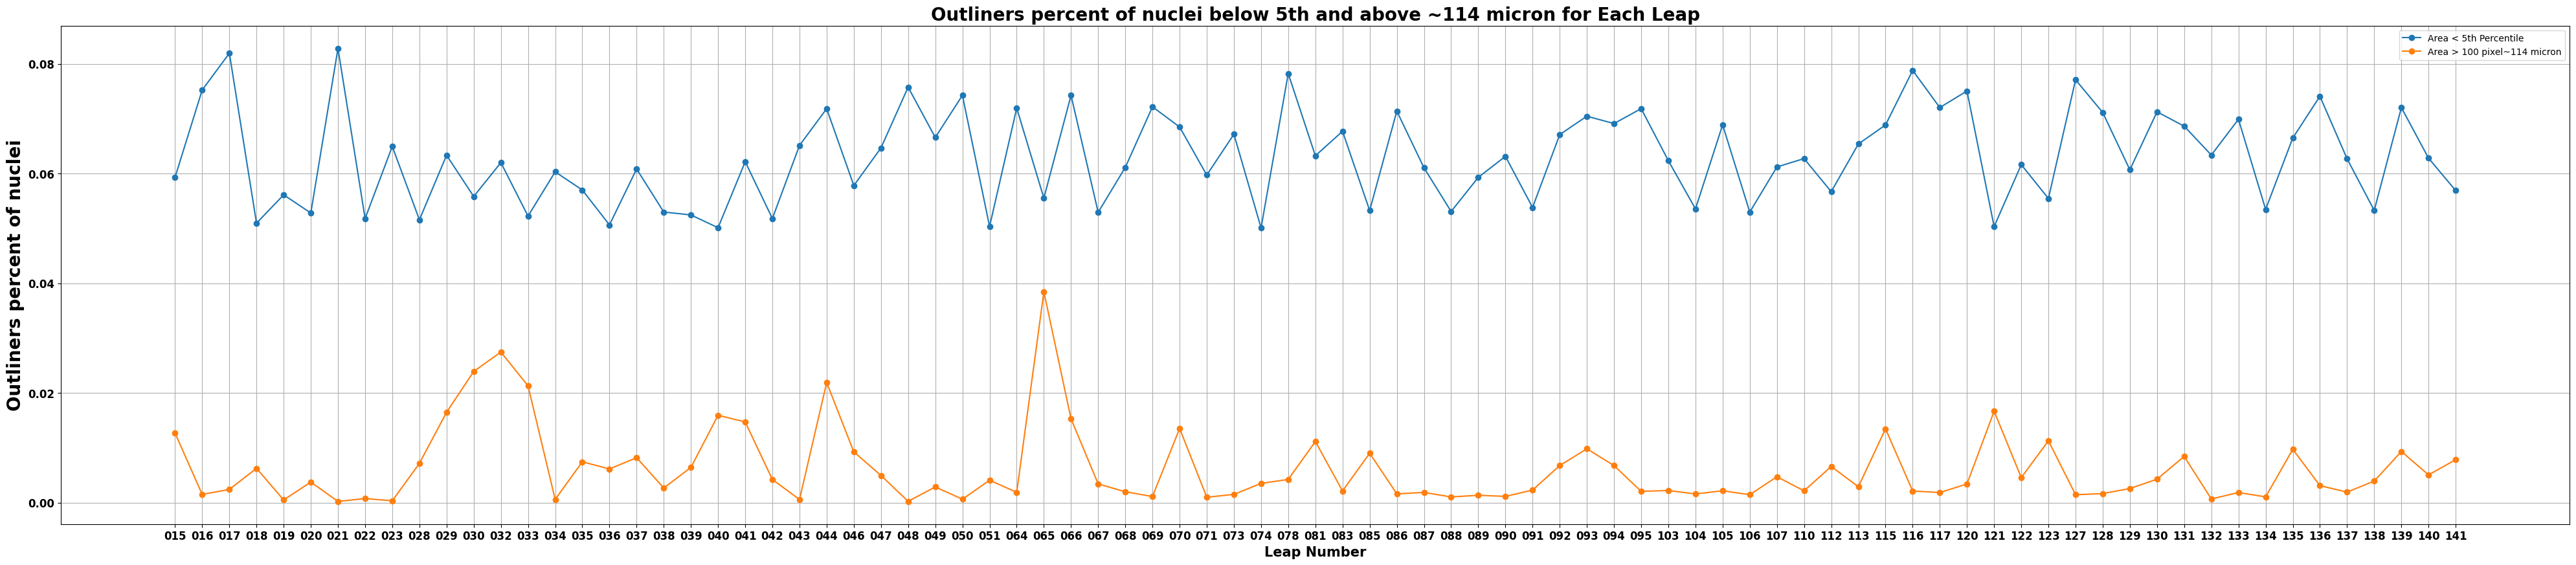

In [28]:

# Visualize the mean areas for all leaps
plt.figure(figsize=(50, 10))
plt.plot(sorted_leaps_list, sorted_lower_percent_list, label='Area < 5th Percentile', marker='o')
plt.plot(sorted_leaps_list, sorted_upper_percent_list, label='Area > 100 pixel~114 micron', marker='o')
plt.xlabel('Leap Number',fontsize=15, fontweight='bold')
plt.ylabel('Outliners percent of nuclei',fontsize=20, fontweight='bold')
plt.title('Outliners percent of nuclei below 5th and above ~114 micron for Each Leap', fontsize=20, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)


plt.show()

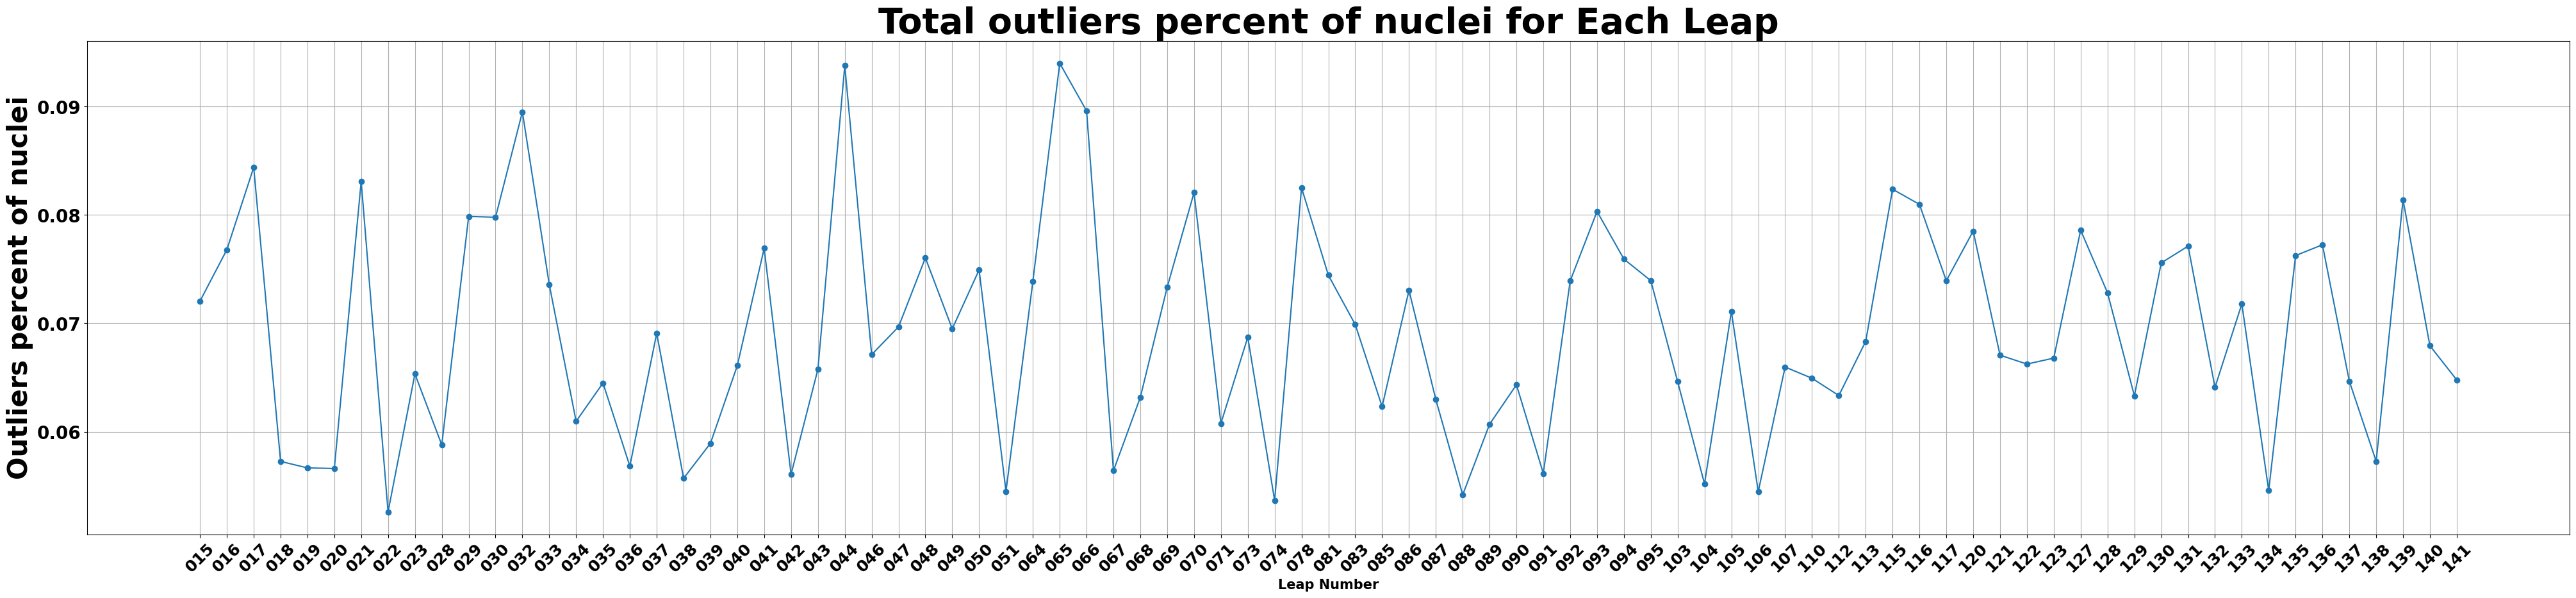

In [29]:
# Visualize the mean areas for all leaps
plt.figure(figsize=(50, 10))
plt.plot(sorted_leaps_list, total, marker='o')
plt.xlabel('Leap Number',fontsize=15, fontweight='bold')
plt.ylabel('Outliers percent of nuclei',fontsize=30, fontweight='bold')
plt.title('Total outliers percent of nuclei for Each Leap', fontsize=40, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold', rotation=45)
plt.yticks(fontsize=20, fontweight='bold')
plt.grid(True)
plt.grid(True)


plt.show()

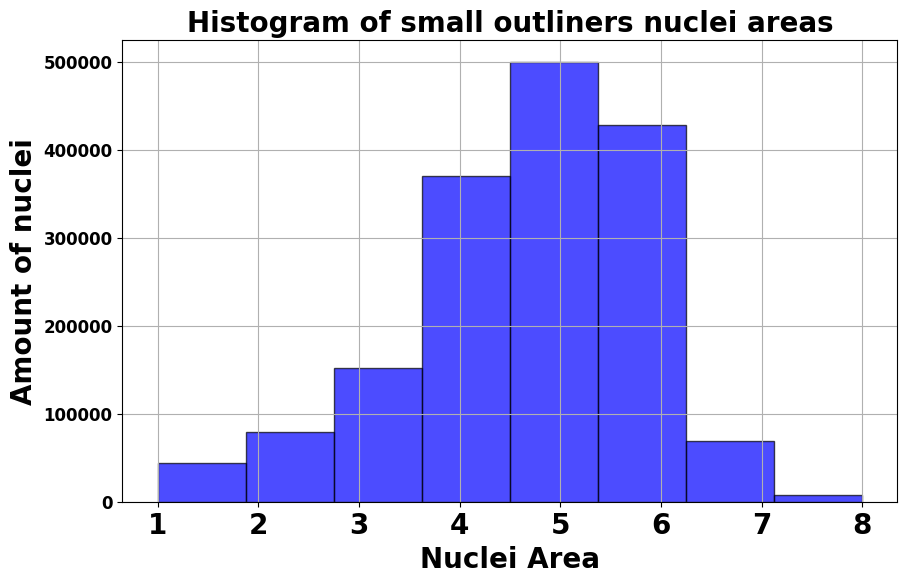

In [16]:
plt.figure(figsize=(10, 6))


# Plot histogram of all areas
plt.hist(lower_area_list, bins=8, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel('Nuclei Area', fontsize=20, fontweight='bold')
plt.ylabel('Amount of nuclei', fontsize=20, fontweight='bold')
plt.title('Histogram of small outliners nuclei areas', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(True)


plt.show()